# Image Processing: Histogram of Oriented Gradients (HOG) with MNIST Dataset

In [52]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [36]:
def apply_hog(img, o = 9, ppc = (8, 8), cpb = (2, 2)):
    # apply HOG to image
    features = hog(
        img,
        orientations = o,
        pixels_per_cell = ppc,
        cells_per_block = cpb,
    )

    return features

In [2]:
# set GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The `MNIST` class loads in the data.
- Train set size: 60000
- Test set size: 10000

All images have size $28\times 28$ pixels.

In [53]:
# load datasets and transform to tensors
mnist_train = MNIST("./data/", download = True, transform = transforms.ToTensor())
mnist_test = MNIST("./data/", train = False, download = True, transform = transforms.ToTensor())

**NOTE:** The `ToTensor()` method transform a `PIL` image into a Torch tensor!

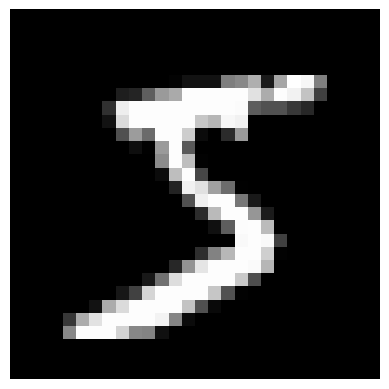

Image Shape: torch.Size([28, 28])
Target: tensor(5)

Train Set (Image): torch.Size([60000, 28, 28])
Train Set (Target): torch.Size([60000])

Test Set (Image): torch.Size([10000, 28, 28])
Test Set (Target): torch.Size([10000])


In [54]:
# sample = first image
sample_image = mnist_train.data[0, :, :]
sample_target = mnist_train.targets[0]

# show image
plt.imshow(sample_image, cmap = "gray")
plt.axis("off")
plt.show()

print("Image Shape:", sample_image.shape)
print("Target:", sample_target)
print()
print("Train Set (Image):", mnist_train.data.shape)
print("Train Set (Target):", mnist_train.targets.shape)
print()
print("Test Set (Image):", mnist_test.data.shape)
print("Test Set (Target):", mnist_test.targets.shape)

In [89]:
targets = mnist_train.targets
print(targets)
print(targets.shape)
print(targets.reshape(1, -1))

tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])
tensor([[5, 0, 4,  ..., 5, 6, 8]])


Apply `OneHotEncoder` to the targets. Each label will be expanded to 10 dimensions.
- `reshape(-1, 1)`: changes the dimensions of the target into a $N\times 1$ vector
- `reshape(1, -1)`: changes the dimensions of the target into a $1\times N$ vector (**not what we want**)

In [80]:
# initialize one hot encoder for targets
enc = OneHotEncoder(sparse = False)
enc.fit(targets.reshape(-1, 1))
print(list(enc.get_feature_names_out()))
print(enc.transform([[1]]))

['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7', 'x0_8', 'x0_9']
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


**NOTE:** The `OneHotEncoder` needs the input to be reshaped by `reshape(-1, 1)`!

The HOG function with the following parameters outputs a 1D feature array of size 144.
- `orientations = 9`
- `pixels_per_cell = (8, 8)`
- `cells_per_block = (2, 2)`

In [58]:
# apply HOG to sample image
sample_features = apply_hog(sample_image)
print(sample_features.shape)

(144,)


In [63]:
# define SVM model
INPUT_FEATURES = sample_features.shape[0]
OUTPUT_CLASSES = 10

model = nn.Linear(144, 10).to(device)
criterion = nn.MultiLabelMarginLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [64]:
# initialize data loader
BATCH_SIZE = 128
train_loader = DataLoader(mnist_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(mnist_test, batch_size = BATCH_SIZE, shuffle = False)

The model will traverse the entire dataset `num_epochs` times. In each epoch, the model will be trained at `BATCH_SIZE` samples at a time.

In [122]:
# train model
counter = 0

losses = []
num_epochs = 2
for it in range(num_epochs):
    for images, labels in train_loader:
        # apply OneHotEncoder to labels (after reshaping)
        labels = enc.transform(labels.reshape(-1, 1))

        # apply HOG to images
        print(type(images), type(labels))
        features = np.array([ apply_hog(img[0]) for img in images ])
        print(features.shape)

        # convert to tensors
        features = torch.from_numpy(features).float().to(device)
        labels = torch.from_numpy(labels).float().to(device)

        counter += 1
        if counter >= 0:
            break

<class 'torch.Tensor'> <class 'numpy.ndarray'>
(128, 144)
<class 'torch.Tensor'> <class 'numpy.ndarray'>
(128, 144)


In [126]:
torch.tensor([ 1, 2, 3]).transforms.Lambda(apply_hog)

AttributeError: 'Tensor' object has no attribute 'transforms'